In [128]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay,PrecisionRecallDisplay)

In [129]:
# ensure jupyter plotting works
%matplotlib inline

In [130]:
# datese path
data_path = r"C:\Users\thura\Downloads\BonusLink - Senior Data Analyst\dataset"

In [131]:
# load CSVs
transactions = pd.read_csv(os.path.join(data_path, "transactions.csv"))
members = pd.read_csv(os.path.join(data_path, "members.csv"))
engagement = pd.read_csv(os.path.join(data_path, "engagement.csv"))

In [132]:
# merge all data
df = transactions.merge(members, on='member_id', how='left').merge(engagement, on='member_id', how='left')

In [133]:
# preprocessing & feature engineering
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [134]:
# add target label: churned if no transactions in the last 3 months
cutoff_date = df['timestamp'].max() - pd.Timedelta(days=90)
last_txn = df.groupby('member_id')['timestamp'].max().reset_index()
last_txn['churn'] = last_txn['timestamp'] < cutoff_date

In [135]:
# aggregate features
agg_df = df.groupby('member_id').agg({
    'spend_amount': ['sum', 'mean', 'count'],
    'timestamp': ['min', 'max'],
    'merchant_id': 'nunique',
    'tier': 'first',
    'age_group': 'first',
    'state': 'first'
}).reset_index()

agg_df.columns = [
    'member_id', 'total_spend', 'avg_spend', 'txn_count',
    'first_txn', 'last_txn', 'unique_merchants',
    'tier', 'age_group', 'state'
]

In [136]:
# duration features
latest_txn_date = df['timestamp'].max()
agg_df['days_since_first_txn'] = (latest_txn_date - agg_df['first_txn']).dt.days
agg_df['days_since_last_txn'] = (latest_txn_date - agg_df['last_txn']).dt.days

In [137]:
# merge engagement + churn
agg_df = agg_df.merge(engagement, on='member_id', how='left')
agg_df = agg_df.merge(last_txn[['member_id', 'churn']], on='member_id', how='left')

In [138]:
# drop unused columns
agg_df.drop(['member_id', 'first_txn', 'last_txn'], axis=1, inplace=True)

In [139]:
# handle missing values
agg_df.fillna(0, inplace=True)

In [140]:
# feature matrix and target
X = agg_df.drop(columns='churn')
y = agg_df['churn']

In [141]:
# feature types
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

In [142]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

In [143]:
# pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

clf = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

In [144]:
# train the model
clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['total_spend', 'avg_spend',
                                                   'txn_count',
                                                   'unique_merchants',
                                                   'days_since_first_txn',
                                                   'days_since_last_txn',
                                                   'monthly_logins',
                                                   'redemptions',
                                                   'app_opens']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['tier', 'age_group',
                                                   'state'])])),
                ('model', LogisticRegression(max_ite

In [145]:
# pedict
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [146]:
# evaluation
print("\n📈 Classification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))

precision, recall, _ = precision_recall_curve(y_test, y_proba)
print("PR AUC:", round(auc(recall, precision), 4))


📈 Classification Report:

              precision    recall  f1-score   support

       False       0.97      1.00      0.98        97
        True       1.00      0.89      0.94        28

    accuracy                           0.98       125
   macro avg       0.98      0.95      0.96       125
weighted avg       0.98      0.98      0.98       125

ROC AUC: 0.9978
PR AUC: 0.9928


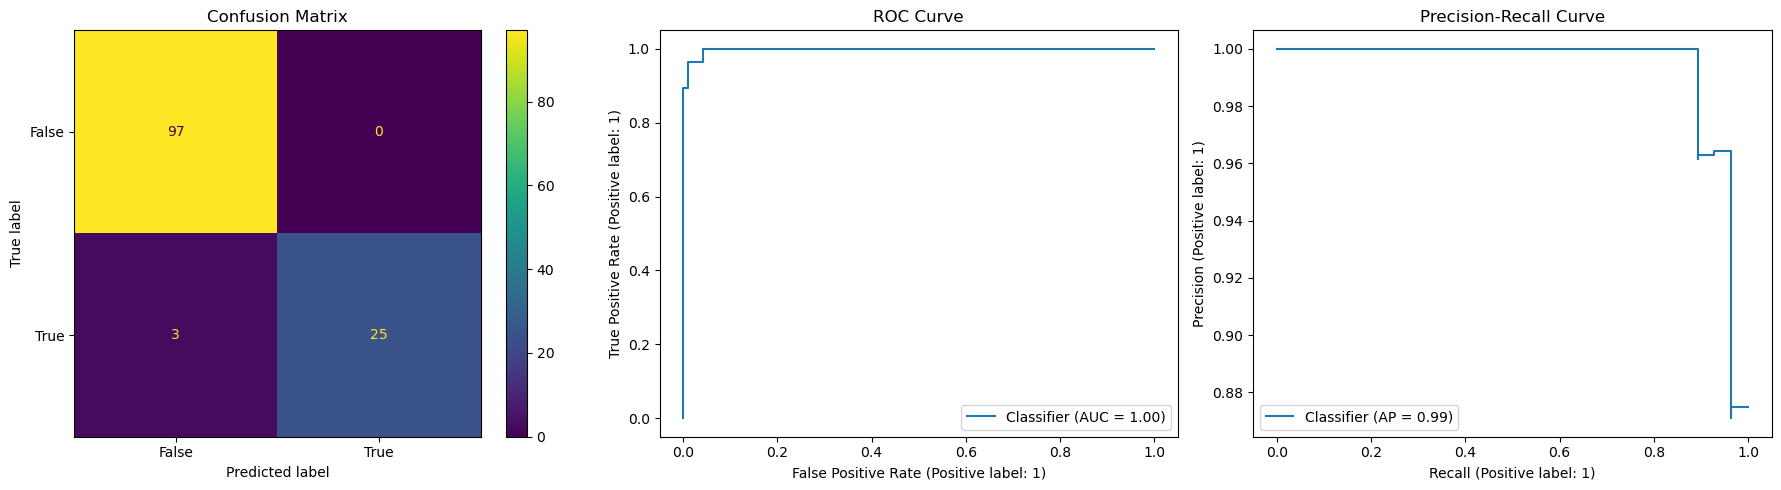

In [147]:
# Plot Evaluation Metrics
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0])
ax[0].set_title("Confusion Matrix")

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax[1])
ax[1].set_title("ROC Curve")

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=ax[2])
ax[2].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

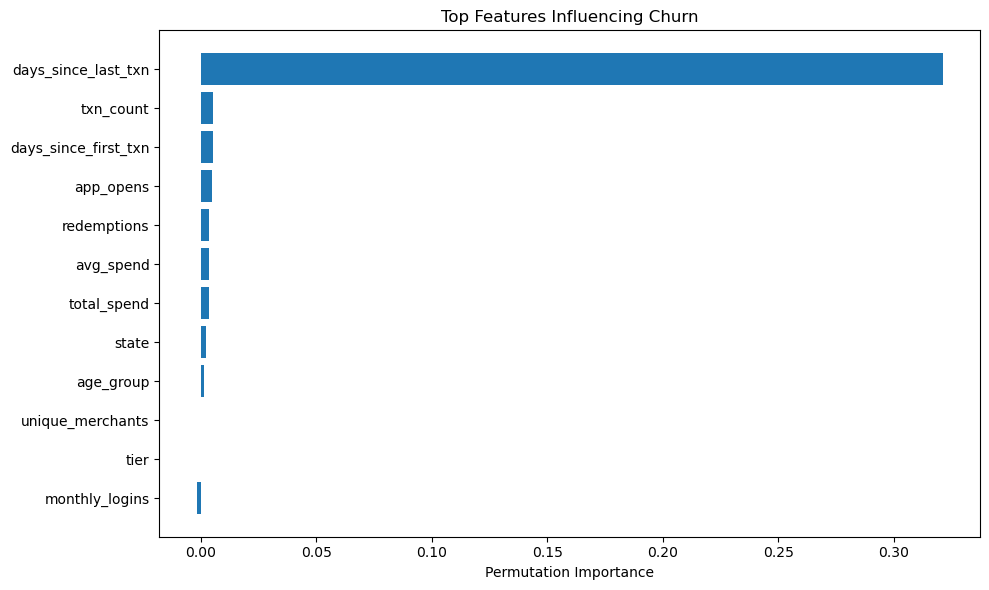

In [149]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
r = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)

# Visualize
import matplotlib.pyplot as plt
import numpy as np

sorted_idx = r.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.barh(np.array(X_test.columns)[sorted_idx], r.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Top Features Influencing Churn")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
